Look here: /glade/campaign/collections/rda/data/ds628.1/anl_surf125/1958/anl_surf125.001_pres.195801_195812

## Do this with bash because grib to netcdf

In [1]:
import xarray as xr
import glob
import os
import numpy as np
import pandas as pd
from dask.diagnostics import ProgressBar
import time
from dask import delayed
from dask import delayed, persist
import dask
import matplotlib.pyplot as plt
import xesmf as xe
import copy

In [2]:
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')
print('STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc')

STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_cdo_out.nc
STOP, JUST MERGE WITH CDO: cdo -b F64 -f nc2 mergetime ei.moda.an.sfc.regn128sc.*.nc test_c

## Functions

In [3]:
def calculate_nansum(dataset,var_bad,variable_name='t2m'):
    
    bv1 = var_bad[0]
    bv2 = var_bad[1]
    
    # Check if A002 and A003 variables exist in the dataset
    if bv1 not in dataset.data_vars or bv2 not in dataset.data_vars:
        raise ValueError("The dataset must contain 'A002' and 'A003' variables.")

    # Extract the 'A002' and 'A003' variables
    A002 = dataset[bv1]
    A003 = dataset[bv2]

    # Sum the variables along the time dimension
    # t2m = A002 + A003    
    t2m = xr.zeros_like(A002)
    
    for ee,ii in enumerate(A002['time']):
        
        #ensure that either A002 or A003 is nan's
        #Check if there are any non-NaN values in the result
        
        if (not np.isnan(A002.sel(time=ii)).all()) and (not np.isnan(A003.sel(time=ii)).all()):
            raise ValueError("Both bad vars contain real values ... ")
        if (np.isnan(A002.sel(time=ii)).all()) and (np.isnan(A003.sel(time=ii)).all()):
            raise ValueError("Both bad vars contain nan values ... ")
        
        t2m[ee, :, :] = np.nansum([A002.sel(time=ii), A003.sel(time=ii)], axis=0)
    dataset = dataset.assign({variable_name: t2m})

    return dataset

## Replace any NAN values

In [4]:
# dir_JRA55_obs = '/glade/scratch/wchapman/JRA55_regrid_out/'
# vary = 'anl_p125.011_tmp.'
# vary_name = 't'
# FNS = sorted(glob.glob(dir_JRA55_obs+vary+'*.nc'))
# bad_fils =[]
# bad_vary_names = []
# for fn in FNS: 
#     DScheck = xr.open_dataset(fn)
#     if vary_name not in DScheck.data_vars.keys():
#         print('inspect: ',fn)
#         bad_fils.append(fn)
#         bad_vary_names.append(DScheck.data_vars.keys())
# keep_names = []

# for ee,fils in enumerate(bad_fils): 
#     keep_names = []
#     for vv in bad_vary_names[ee]:
#         keep_names.append(vv)
    
#     DSchange = xr.open_dataset(fils)
#     t2m =calculate_nansum(DSchange,keep_names,variable_name=vary_name)
#     t2m.to_netcdf(dir_JRA55_obs + 'V2_'+fils.split('/')[-1])
    
# #rename the v2 files and over write
# files_to_rename = sorted(glob.glob('/glade/scratch/wchapman/JRA55_regrid_out/V2_*'))
# for fl in files_to_rename: 
#     print(fl)
    # os.rename(fl,fl.split('V2_')[0]+fl.split('V2_')[1])

## Regrid and Append everything:

In [7]:
dir_JRA55_obs = '/glade/scratch/wchapman/ERAi_regrid_out/'
vary = 'ei.moda.an.sfc.regn128sc.'
svout = '/glade/work/wchapman/JRA55_Obs/'+'ei.moda.an.sfc.regn128sc.V3.1979-2010.nc'
svout2 = '/glade/work/wchapman/JRA55_Obs/'+'ei.moda.an.sfc.regn128sc.V3.camgrid.1979-2010.nc'

######## use cdo ...# FNS = sorted(glob.glob(dir_JRA55_obs+vary+'*.nc'))
######## use cdo ...# DSfin = xr.open_mfdataset(FNS)
######## use cdo ...# DSfin = DSfin.sel(time=slice('1979-01-01','2010-12-31'))
######## use cdo ...# print('...loading...')
######## use cdo ...# DSfin.load()
######## use cdo ...# print('...saving...')
######## use cdo ...# DSfin.to_netcdf(svout)

# #regrid to camgrid ... 
# #grab an example file to get the grid: 
fns = sorted(glob.glob('/glade/campaign/cisl/aiml/wchapman/CAM_runs/Nudge_DA/f.e21.DAcompset.f09_d025_Seasonal_DA_stochai_UV_03_1982_r1/atm/hist/*h0*.nc'))
DScamgrid = xr.open_dataset(fns[0])
DScamgrid

#set lat/lon to regrid to: 
latcam = DScamgrid.lat
loncam = DScamgrid.lon

#make regridder structure:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.array(DScamgrid.lat)),
        "lon": (["lon"], np.array(DScamgrid.lon)),
    }
)
#open the GPCP file: 

DSall = xr.open_dataset(svout)
DSall =DSall.rename({"longitude": "lon"})
DSall =DSall.rename({"latitude": "lat"})
# ##build regridder method: 
regridder = xe.Regridder(DSall, ds_out, "bilinear")
# #regrid. 
ds_out = regridder(copy.deepcopy(DSall)) #this is an xarray instance now. 
    #compute from xarray in dask 
    #save:
print('saving... ',svout2)
ds_out.to_netcdf(svout2)

Overwrite existing file: bilinear_256x512_192x288.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable cvl as the horizontal dimensions for this dataset.


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/xesmf/frontend.py:486: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


saving...  /glade/work/wchapman/JRA55_Obs/ei.moda.an.sfc.regn128sc.V3.camgrid.1979-2010.nc


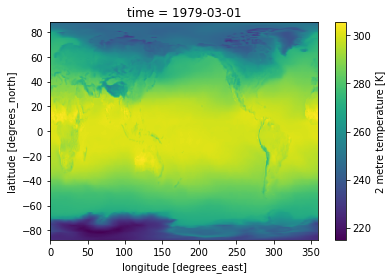

In [8]:
DSall['t2m'].sel(lat=slice(88,-88)).isel(time=2).plot()
plt.show()

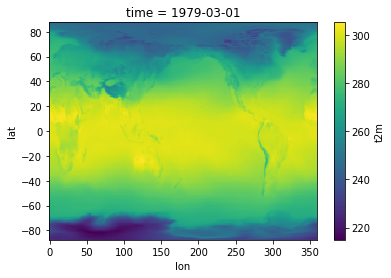

In [9]:
ds_out['t2m'].sel(lat=slice(-88,88)).isel(time=2).plot()
plt.show()